# Is There A Relationship Between Socioeconomic Factors and ACT Scores?

## Introduction

This project looks to determine if there is a relationship between socioeconomic characteristics of school districts and their average ACT scores. To accomplish this task, I used NCES and EdGap school data from the 2016-17 school year. Using this data, I created 6 single variable linear regression models, each one modeling the linear relationship between a socioeconomic variable and the average ACT scores, as well as a multiple linear regression model, representing the relationship between all the socioeconomic variables and the average ACT scores. Looking at the p-values for these models, we can determine whether the relationships between the socioeconomic variables and the average ACT scores is related or not.

## Data Processing and Cleaning

In [56]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_style("whitegrid")

### Clean the datasets, and then merge them

Here, we're reading in the excel file containing the education gap data.

In [57]:
edgap = pd.read_excel(
    'https://raw.githubusercontent.com/brian-fischer/DATA-5100/main/EdGap_data.xlsx',
    dtype={'NCESSCH School ID': object}
)

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning:

Unknown extension is not supported and will be removed



Here, we're downloading the school information dataset from dropbox, and then reading it in as a csv.

In [58]:
!wget -O ccd_sch_029_1617_w_1a_11212017.csv https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=0

--2025-10-22 00:13:56--  https://www.dropbox.com/s/lkl5nvcdmwyoban/ccd_sch_029_1617_w_1a_11212017.csv?dl=0
Resolving proxy.server (proxy.server)... 10.0.0.66
Connecting to proxy.server (proxy.server)|10.0.0.66|:3128... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/o8wf1f534pb4u7uavgjxm/ccd_sch_029_1617_w_1a_11212017.csv?rlkey=k2aey38xie2vz9ge4a0v3rrib&dl=0 [following]
--2025-10-22 00:13:57--  https://www.dropbox.com/scl/fi/o8wf1f534pb4u7uavgjxm/ccd_sch_029_1617_w_1a_11212017.csv?rlkey=k2aey38xie2vz9ge4a0v3rrib&dl=0
Reusing existing connection to www.dropbox.com:443.
Proxy request sent, awaiting response... 302 Found
Location: https://uca3568e6823e9273a12fed0bdf3.dl.dropboxusercontent.com/cd/0/inline/CzozaKjaXflrGMt57Qdna6p7vuebRX7-Xd1tD2zlK1cA0xIYEuYfpu3DNc6RxKeSAOJA1DHfEoyV4n-VZORJGhp61uT96KIkMsblA7zFBnLPCnZHFuhCA8Q8wnUoyRNivhU/file# [following]
--2025-10-22 00:13:57--  https://uca3568e6823e9273a12fed0bdf3.dl.dropboxusercontent.

In [59]:
school_information = pd.read_csv(
    "ccd_sch_029_1617_w_1a_11212017.csv", encoding="unicode_escape"
)

/tmp/ipykernel_11425/2591098979.py:1: DtypeWarning:

Columns (6,9,14,15,18,19,21,22,25,26,29,31,35,39,41,42) have mixed types. Specify dtype option on import or set low_memory=False.



Here, we're downloading the additional dataset I will be using for this analysis, student-teacher ratio.

In [60]:
student_teacher_ratio = pd.read_csv(
    "ELSI_csv_export_6389564675853507038315.csv", skiprows=5
)

Here, we're filtering the school information and student_teacher_ratio datasets for only the variables we care about.

In [61]:
school_information = school_information[
    ['SCHOOL_YEAR', 'NCESSCH', 'LSTATE', 'LZIP', 'SCH_TYPE_TEXT', 'LEVEL', 'CHARTER_TEXT']
]

student_teacher_ratio = student_teacher_ratio[["School ID (12-digit) - NCES Assigned [Public School] Latest available year", 
                                               "Pupil/Teacher Ratio [Public School] 2016-17"]]

We're going to rename the variables in all three datasets for ease of use, and to allow us to merge on the NCESSCH codes.

In [62]:
school_information = school_information.rename(
    columns={
        "SCHOOL_YEAR": "year",
        "NCESSCH": "id",
        "LSTATE": "state",
        "LZIP": "zip_code",
        "SCH_TYPE_TEXT": "school_type",
        "LEVEL": "school_level",
        "CHARTER_TEXT": "charter"
    }
)

In [63]:
edgap = edgap.rename(
    columns={
        "NCESSCH School ID": "id",
        "CT Pct Adults with College Degree": "percent_college",
        "CT Unemployment Rate": "rate_unemployment",
        "CT Pct Childre In Married Couple Family": "percent_married",
        "CT Median Household Income": "median_income",
        "School ACT average (or equivalent if SAT score)": "average_act",
        "School Pct Free and Reduced Lunch": "percent_lunch",
    }
)

In [64]:
student_teacher_ratio = student_teacher_ratio.rename(
    columns={
        "School ID (12-digit) - NCES Assigned [Public School] Latest available year": "id",
        "Pupil/Teacher Ratio [Public School] 2016-17": "pupil_teach_ratio"
    }
)

Here, we're going to replace any missing data with NaN values for the student_teacher_ratio, and then convert the datatype to a float so we can look at the relationship between the student-teacher ratio and the ACT scores.

In [65]:
student_teacher_ratio["pupil_teach_ratio"] = student_teacher_ratio["pupil_teach_ratio"].replace("†", np.nan)
student_teacher_ratio["pupil_teach_ratio"] = student_teacher_ratio["pupil_teach_ratio"].replace("–", np.nan)
student_teacher_ratio["pupil_teach_ratio"] = student_teacher_ratio["pupil_teach_ratio"].astype("float")

Here, we are converting the School ID to an object type in both the student information and student teacher ratio datasets, so we can merge it with the edgap dataset.

In [66]:
student_teacher_ratio["id"] = student_teacher_ratio["id"].astype("object")

In [67]:
school_information['id'] = school_information['id'].astype('object')

Here, we're merging the datasets on the 'id' variable.

In [68]:
df = edgap.merge(
    school_information,
    how='left',
    on='id'
)

df = df.merge(
    student_teacher_ratio,
    how='left',
    on='id'
)

### Look for outliers, and replace NaN values

We start by looking at summary statistics for the dataset.

In [70]:
df.describe()

,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,pupil_teach_ratio
count,7972.000000,7973.000000,7961.000000,7966.000000,7986.000000,7986.000000,7846.000000
mean,0.098730,0.568930,0.633440,52026.905222,20.181532,0.420651,17.106326
std,0.058959,0.165704,0.196764,24228.057079,2.595201,0.239754,74.519133
min,0.000000,0.091493,0.000000,3589.000000,-3.070818,-0.054545,3.860000
25%,0.058655,0.450828,0.523810,36597.250000,18.600000,0.238501,13.480000
50%,0.085649,0.554979,0.667594,46833.500000,20.400000,0.381570,15.820000
75%,0.123376,0.676571,0.777135,61369.250000,21.910867,0.575447,18.360000
max,0.590278,1.000000,1.000000,226181.000000,32.362637,0.998729,6592.000000


Here, we can see that there are a number of missing values for all the categories except for average_act and percent_lunch. In addition, some of the max values for these areas are outside the realm of possibility. We know the ACT scores range from 1 to 36, so any values outside of those ranges are impossible. In addition, all the percentages should be between 0% and 100%, so the percent_lunch category could not have negative values. Finally, there is no chance that there is a school with a student-teacher ratio of 6592. To fix this, we will remove any extreme outliers.

In [71]:
df.loc[df['percent_lunch'] <0, 'percent_lunch'] = np.nan

In [72]:
df.loc[df['average_act'] <1, 'average_act'] = np.nan

In [76]:
df.loc[df['pupil_teach_ratio'] >100, 'pupil_teach_ratio'] = np.nan

After removing any outliers, we'll now double check the categorical data, to remove anything that doesn't make sense to consider when looking at ACT scores. 

In [78]:
df['school_type'].value_counts()

school_type
Regular School                 7885
Alternative School               10
Special Education School          2
Career and Technical School       1
Name: count, dtype: int64

In [79]:
df['school_level'].value_counts()

school_level
High            7230
Other            631
Not reported      35
Elementary         2
Name: count, dtype: int64

In [80]:
df['charter'].value_counts()

charter
No                7329
Yes                352
Not applicable     217
Name: count, dtype: int64

As we are looking at ACT scores, it doesn't make sense to keep any schools other than High Schools, as thats when the ACT scores are taken. 

In [81]:
df = df.loc[df['school_level'] == 'High']

Finally, we want to check the number of NaN values in each category, and impute the values that are missing. 

We start by removing any data where the ACT scores are NaN, as without an ACT score the data is not relevant to this study. 

In [82]:
df = df.dropna(subset = ['average_act'])

From here, we can check the number of NaN values in each category.

In [83]:
df.isna().sum().to_frame(name='Number of Missing Values')

,Number of Missing Values
id,0
rate_unemployment,12
percent_college,11
percent_married,20
median_income,16
average_act,0
percent_lunch,20
year,0
state,0
zip_code,0


From here, we're going to impute the missing values. We start by defining the predictor variables to be used for data imputation.

In [86]:
predictor_variables = [
    'rate_unemployment',
    'percent_college',
    'percent_married',
    'median_income',
    'percent_lunch',
    'state',
    'charter',
    'pupil_teach_ratio'
]

We're going to use an iterative imputer to impute the missing values. To start, we import necesary packages from sklearn, and set the imputer to the imported imputer.

In [87]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [88]:
imputer = IterativeImputer() # Creates imputer object

Here, we're going to fit the imputer using the numerical predictor values that we have. We define the set of predictors that are numerical values, and we will use them in the imputation process.

In [89]:
numerical_predictors = df[predictor_variables].select_dtypes(include='number').columns.to_list()

Here, we're going to fit the imputer with the data from those columns.

In [91]:
imputer.fit(df.loc[:, numerical_predictors]) # Fit the imputer

IterativeImputer()

Finally, we apply the transform method to apply those imputed values to the dataset.

In [92]:
df.loc[:, numerical_predictors] = imputer.transform(df.loc[:, numerical_predictors])

And then, we double check our data to make sure we no longer have any missing values.

In [93]:
df.isna().sum().to_frame(name='Number of Missing Values')

,Number of Missing Values
id,0
rate_unemployment,0
percent_college,0
percent_married,0
median_income,0
average_act,0
percent_lunch,0
year,0
state,0
zip_code,0


Finally, we'll export a clean csv for later analysis if necessary.

## Exploratory Data Analysis

### Exploring the relationships between the socioeconomic data and ACT scores

We're gonna start by looking quickly at the socioeconomic factors to see if there is some sort of relationship between them and the ACT scores.

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



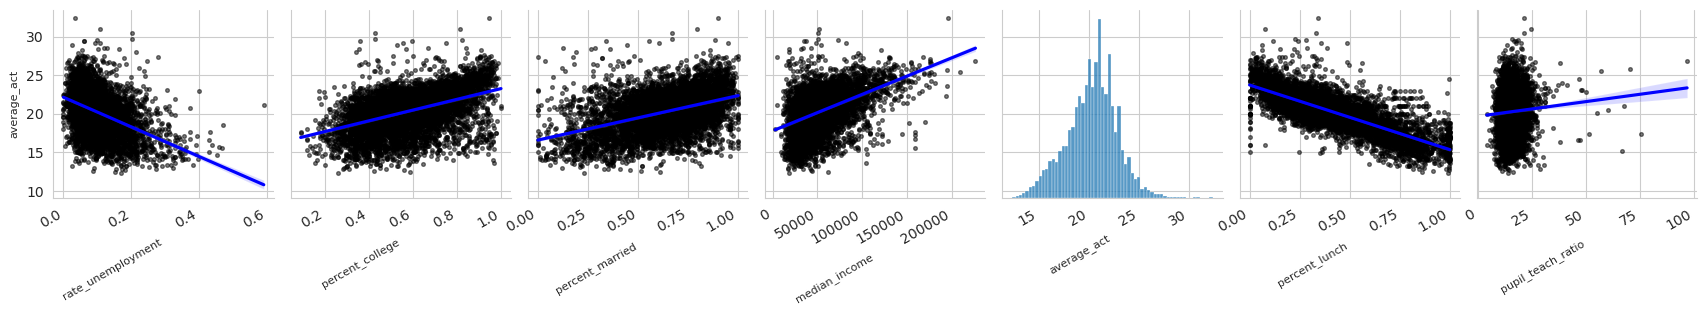

In [95]:
fig = sns.pairplot(
    df.drop(columns="id"),
    y_vars=['average_act'],
    kind="reg",
    plot_kws={
        "line_kws": {"color": "blue"},
        "scatter_kws": {"alpha": 0.5, "color": "k", "s": 7},
    },
)

for ax in fig.axes.flat:
    if ax.get_xlabel() == 'median income':
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))  # Apply scientific notation
    ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=30, ha='right') # X-axis label size and rotation
    ax.set_ylabel(ax.get_ylabel(), fontsize=8) # Y-axis label size

    #Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

Here, it does seem that there is some sort of relationship between the ACT scores and the various socioeconomic factors we wanted to look at. To better identify these relationships, we're going to be importing some additional libraries, and then creating a matrix of the correlation coefficients between the numerical predictor variables and mapping these to a plot. Unfortunately, my chart seems to be bugged, so we'll be printing the correlation coefficient values underneath the chart, as only the first row of numbers seems to show up.

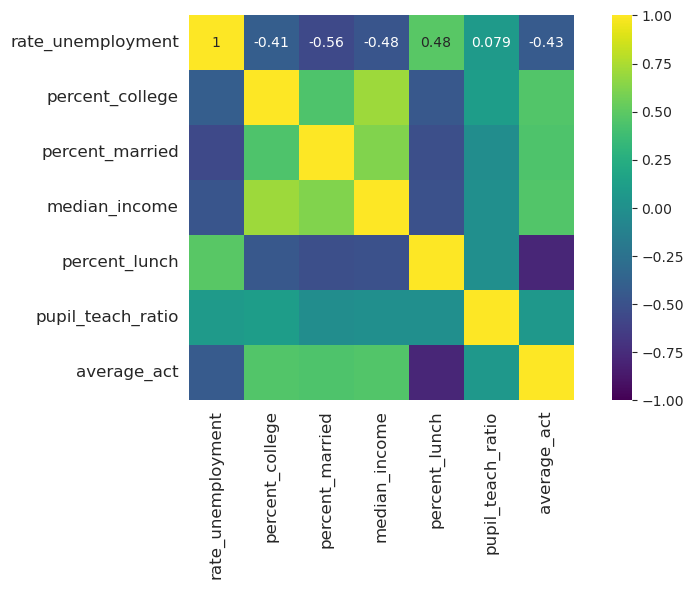

                   rate_unemployment  percent_college  percent_married  \
rate_unemployment           1.000000        -0.413985        -0.561541   
percent_college            -0.413985         1.000000         0.443245   
percent_married            -0.561541         0.443245         1.000000   
median_income              -0.475896         0.706922         0.624598   
percent_lunch               0.476577        -0.459366        -0.516568   
pupil_teach_ratio           0.078623         0.104818        -0.024700   
average_act                -0.433229         0.458378         0.439834   

                   median_income  percent_lunch  pupil_teach_ratio  \
rate_unemployment      -0.475896       0.476577           0.078623   
percent_college         0.706922      -0.459366           0.104818   
percent_married         0.624598      -0.516568          -0.024700   
median_income           1.000000      -0.505662          -0.010143   
percent_lunch          -0.505662       1.000000          

In [108]:
predictor_variables = ['rate_unemployment', 'percent_college', 'percent_married', 'median_income', 'percent_lunch', 'state', 'charter', 'pupil_teach_ratio']

numerical_predictors = df[predictor_variables].select_dtypes(include='number').columns.to_list()

corr_matrix = df[numerical_predictors + ["average_act"]].corr()

plt.figure(figsize=(10, 5))

sns.heatmap(
    corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap="viridis"
)

plt.tick_params(labelsize=12)

plt.show()

print(corr_matrix)

We can see that all numerical variables have some correlation coefficient value with ACT scores, with percent lunch having a significant higher coefficient than the others. In addition to looking at the correlation between ACT scores and the numerical predictors, its also important to note the correlation coefficients between the numerical predictors, to see whether there is enough overlap between two of them to the point we might only need to include one or the other in our analysis. For example, we can see that there is a strong positive coefficient between median_income and percent_college, as well as beteen median_income and percent_married. This could mean in our model that we might only need to include some of these variables rather than all of them, as the relationships between the variables is quite high. 

Here, we're checking to see if whether the school is a charter or not matters for the purpose of modeling the relationship between socioeconomic status and ACT scores.

/opt/conda/envs/anaconda-ai-2024.04-py310/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



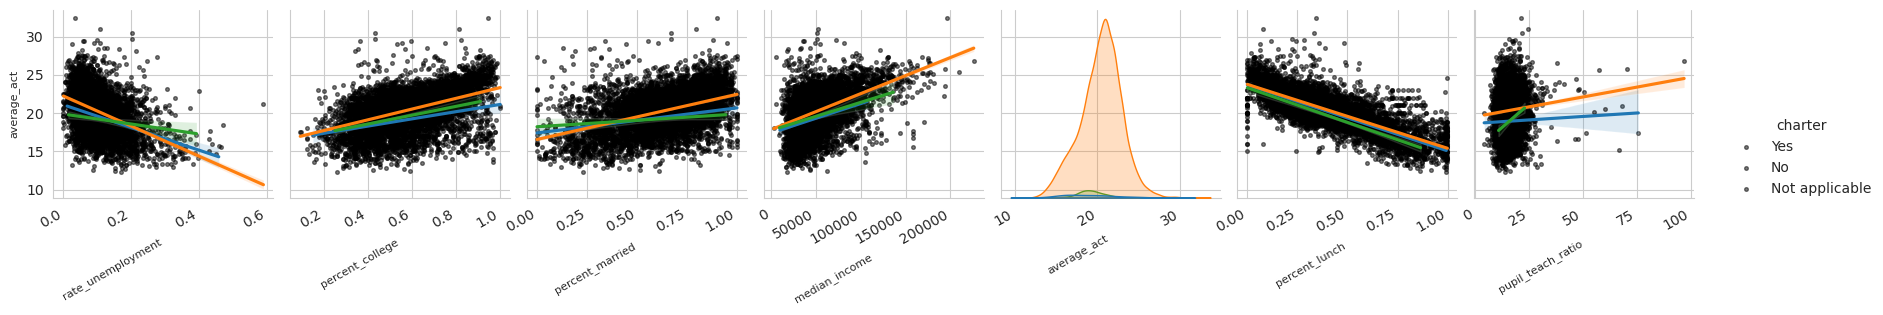

In [112]:
fig = sns.pairplot(
    df.drop(columns="id"),
    y_vars=['average_act'],
    hue='charter',
    kind="reg",
    plot_kws={
        "scatter_kws": {"alpha": 0.5, "color": "k", "s": 7},
    },
)

for ax in fig.axes.flat:
    if ax.get_xlabel() == 'CT Median Household Income':
        ax.ticklabel_format(style="sci", axis='x', scilimits=(0,0)) # Apply scientific notation
    ax.set_xlabel(ax.get_xlabel(), fontsize=8, rotation=30, ha='right') # X-axis label size and rotation
    ax.set_ylabel(ax.get_ylabel(), fontsize=8) # Y-axis label size

    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

For a lot of these charts, the difference between it being a charter school, it not being a charter school, or the charter definition being not applicable doesn't seem to make much of a difference on the trendlines for the relationships between the factors and the ACT scores. The only where there seems to be some notable difference is in the student-teacher ratio relationship, with one of the charter qualifiers have a different trendline compared to the other two.

### Removing some outliers to get a better understanding of the data

In some of these charts, particularly the student-teacher ratio and the unemployment rate, there seem to be a number of outliers that might be potentially skewing the data. To get a better sense of these, we're going to create a series of boxplots. The first set will be for all the percentages, as they are all on the same scale and can be graphed together. After that, we'll create two other boxplots, one for median income, and one for student-teacher ratio, as they have different scales.

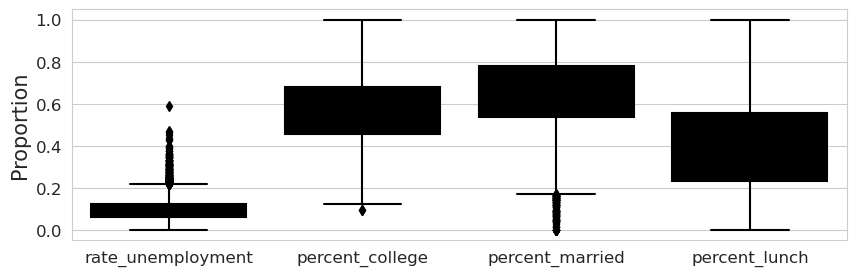

In [113]:
plt.figure(figsize=(10,3))

fractions = list(numerical_predictors)
fractions.remove('median_income')
fractions.remove('pupil_teach_ratio')

sns.boxplot(data=df[fractions], color='k')

plt.ylabel('Proportion', fontsize=15)

plt.tick_params(labelsize=12)

plt.show()

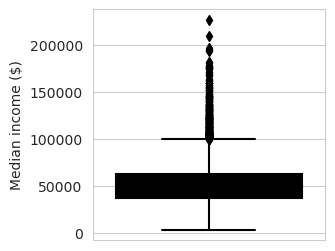

In [114]:
plt.figure(figsize=(3,3))

sns.boxplot(data=df, y='median_income', color='k')

plt.ylabel('Median income ($)')

plt.show()

In these cases, while we can see outliers, it doesn't seem as if the outliers are that out of place, and should still be fine when being used for this analysis.

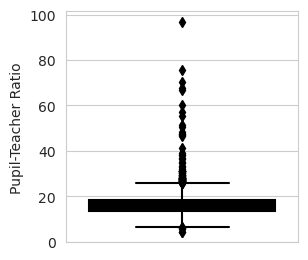

In [116]:
plt.figure(figsize=(3,3))

sns.boxplot(data=df, y='pupil_teach_ratio', color='k')

plt.ylabel('Pupil-Teacher Ratio')

plt.show()

In this case there are a number of extreme outliers, and so its probably worth trying to trim down some of these excessive outliers.

To do this, we're going to remove student-teacher ratios over 34, as according to the NCES, the average student-teacher ratio in the nation is 16, and the highest individual state is 23 in the year 2016-17, which is where our data is coming from. This should eliminate a lot of the outliers that might not make sense, and help us to get a clearer view of our data. 

In [118]:
df_filtered = df[df['pupil_teach_ratio'] < 35]

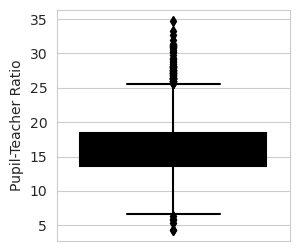

In [120]:
plt.figure(figsize=(3,3))

sns.boxplot(data=df_filtered, y='pupil_teach_ratio', color='k')

plt.ylabel('Pupil-Teacher Ratio')

plt.show()

Here, we can see a much more reasonable representation of our student-teacher data, and can proceed with the rest of the modeling from here.

### Creating regression lines to model the relationships between socioeconomic factors and ACT scores

Here, we're just going to model the relationships between each individual socioeconomic factor and the ACT scores with a linear regression line.

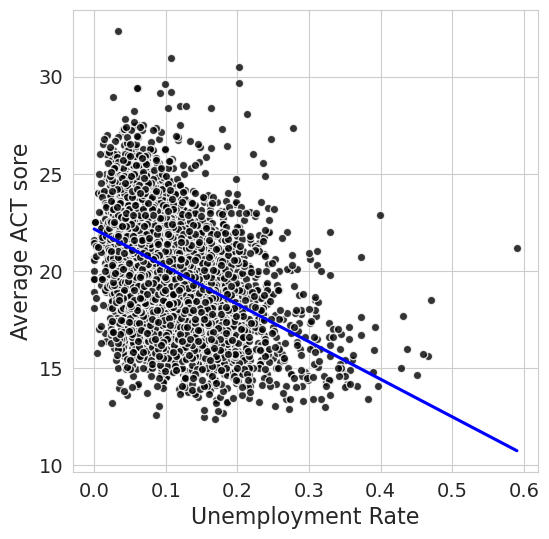

In [141]:
plt.figure(figsize=(6,6))

sns.regplot(data=df_filtered,
            x='rate_unemployment',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths':1})

plt.xlabel('Unemployment Rate', fontsize=16)
plt.ylabel('Average ACT sore', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

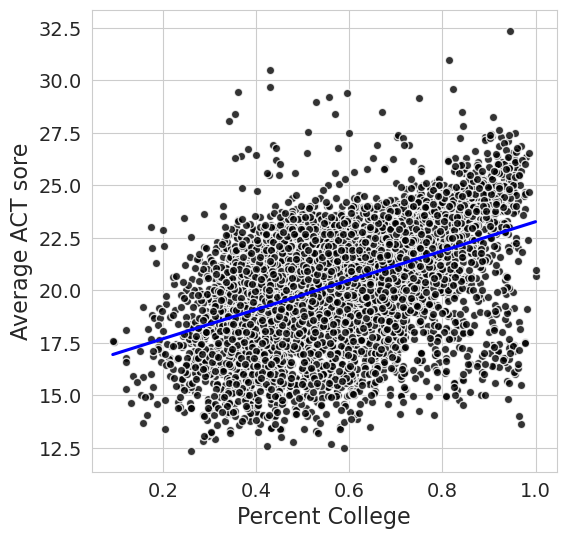

In [142]:
plt.figure(figsize=(6,6))

sns.regplot(data=df_filtered,
            x='percent_college',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths':1})

plt.xlabel('Percent College', fontsize=16)
plt.ylabel('Average ACT sore', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

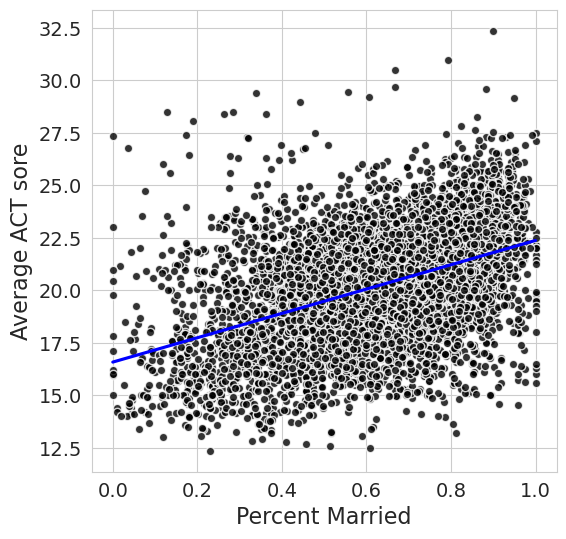

In [143]:
plt.figure(figsize=(6,6))

sns.regplot(data=df_filtered,
            x='percent_married',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths':1})

plt.xlabel('Percent Married', fontsize=16)
plt.ylabel('Average ACT sore', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

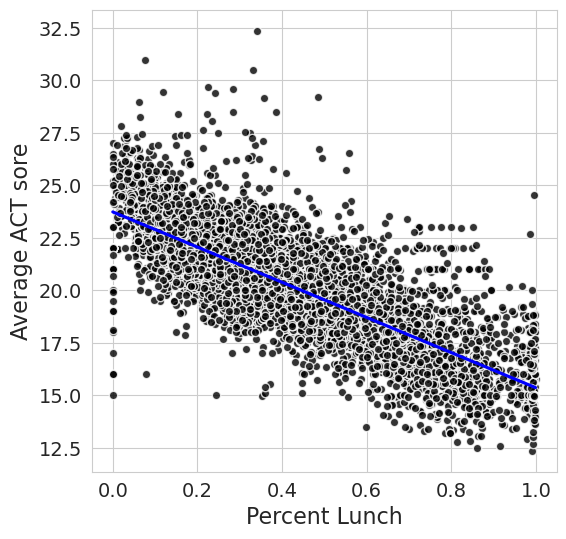

In [144]:
plt.figure(figsize=(6,6))

sns.regplot(data=df_filtered,
            x='percent_lunch',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths':1})

plt.xlabel('Percent Lunch', fontsize=16)
plt.ylabel('Average ACT sore', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

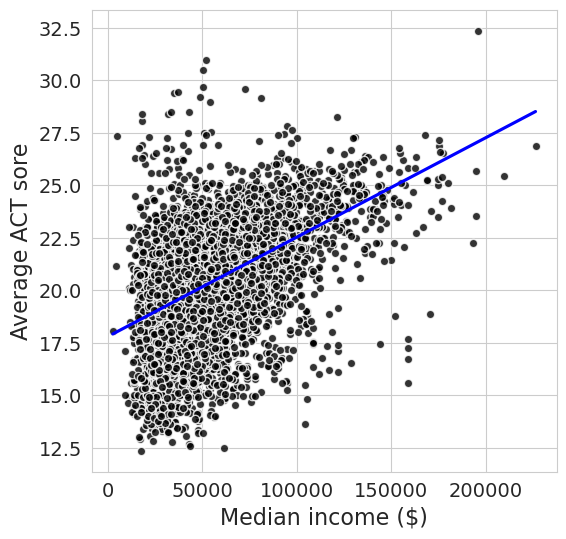

In [145]:
plt.figure(figsize=(6,6))

sns.regplot(data=df_filtered,
            x='median_income',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths':1})

plt.xlabel('Median income ($)', fontsize=16)
plt.ylabel('Average ACT sore', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

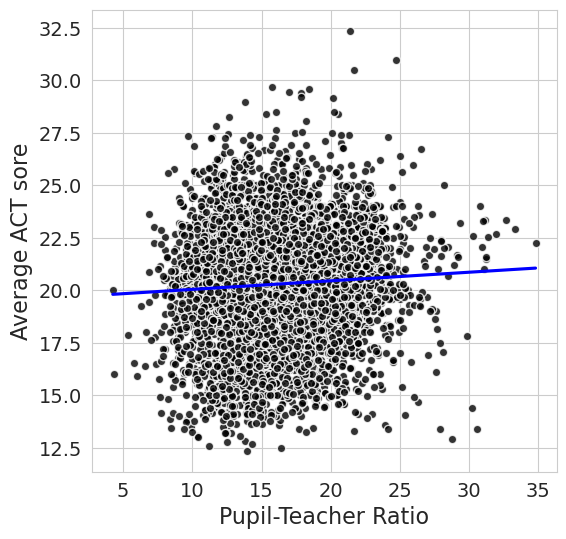

In [146]:
plt.figure(figsize=(6,6))

sns.regplot(data=df_filtered,
            x='pupil_teach_ratio',
            y='average_act',
            color='blue',
            ci=False,
            scatter_kws={'color': 'black', 'edgecolors': 'white', 'linewidths':1})

plt.xlabel('Pupil-Teacher Ratio', fontsize=16)
plt.ylabel('Average ACT sore', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

To determine whether these linear regression lines we've modeled above show a statistically significant relationship, we'll want to create an ordinary least squares model, and then test the p-value to determine statistical significance for each linear regression line.

### Testing statistical significance with an ordinary least squares model of the linear regression lines

In [147]:
model_rate_unemployment = smf.ols(formula='average_act ~ rate_unemployment', data=df_filtered).fit()
print(model_rate_unemployment.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     1676.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        02:16:40   Log-Likelihood:                -16081.
No. Observations:                7205   AIC:                         3.217e+04
Df Residuals:                    7203   BIC:                         3.218e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.1569      0.05

In [148]:
model_percent_college = smf.ols(formula='average_act ~ percent_college', data=df_filtered).fit()
print(model_percent_college.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     1919.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        02:16:41   Log-Likelihood:                -15984.
No. Observations:                7205   AIC:                         3.197e+04
Df Residuals:                    7203   BIC:                         3.199e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.3066      0.095    1

In [149]:
model_percent_married = smf.ols(formula='average_act ~ percent_married', data=df_filtered).fit()
print(model_percent_married.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     1744.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        02:16:42   Log-Likelihood:                -16054.
No. Observations:                7205   AIC:                         3.211e+04
Df Residuals:                    7203   BIC:                         3.213e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.5834      0.093    1

In [150]:
model_percent_lunch = smf.ols(formula='average_act ~ percent_lunch', data=df_filtered).fit()
print(model_percent_lunch.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                 1.144e+04
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        02:16:43   Log-Likelihood:                -13409.
No. Observations:                7205   AIC:                         2.682e+04
Df Residuals:                    7203   BIC:                         2.684e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.7347      0.037    641.169

In [151]:
model_median_income = smf.ols(formula='average_act ~ median_income', data=df_filtered).fit()
print(model_median_income.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     1947.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        02:16:44   Log-Likelihood:                -15973.
No. Observations:                7205   AIC:                         3.195e+04
Df Residuals:                    7203   BIC:                         3.196e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        17.7927      0.062    284.883

In [152]:
model_pupil_teach_ratio = smf.ols(formula='average_act ~ pupil_teach_ratio', data=df_filtered).fit()
print(model_pupil_teach_ratio.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     25.56
Date:                Wed, 22 Oct 2025   Prob (F-statistic):           4.40e-07
Time:                        02:16:44   Log-Likelihood:                -16822.
No. Observations:                7205   AIC:                         3.365e+04
Df Residuals:                    7203   BIC:                         3.366e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            19.6362      0.13

There are three important values to pay attention to in these models. The first is the p-value. If the p-value is less than 0.05, that means the relationship between the socioeconomic factor and the ACT scores is statistically significant. The second is the r-squared value. This is on a scale of 0 to 1, and is a normalized measure that tells you how good your model is at predicting the value. The higher the r-squared value, the better the model is at predicting the ACT score from the socioeconomic factor being chosen. The final value to pay attention to is the sign of the coefficient of the socioeconomic variable. If its positive, it indicates a positive relationship between the ACT score and the variable. If its negative, it indicates a negative relationship between them. 

In the models above, we can see that the factor that is best at indicating the ACT score is percent_lunch, with an r-squared value of 0.614, compared to the other factors, where the highest is a 0.213. This shows that the best indicator for ACT scores from the socioeconomic factors we're looking at is percent_lunch. Its also important to note that for all of these one variable models, the variables are also statistically significant.

### Calculating Mean Squared Errors for all the models

Here, we're gonna calculate the mean absolute error for all our models, which will allow us to see the difference in terms of actual ACT score that our model is off by on average.

In [161]:
y_hat = model_rate_unemployment.predict()
np.sqrt(mean_squared_error(df_filtered['average_act'], y_hat)).round(3)
mean_absolute_error(df_filtered['average_act'], y_hat)

1.7377396732424273

In [162]:
y_hat2 = model_percent_college.predict()
np.sqrt(mean_squared_error(df_filtered['average_act'], y_hat2)).round(3)
mean_absolute_error(df_filtered['average_act'], y_hat2)

1.713148977355379

In [163]:
y_hat3 = model_percent_married.predict()
np.sqrt(mean_squared_error(df_filtered['average_act'], y_hat3)).round(3)
mean_absolute_error(df_filtered['average_act'], y_hat3)

1.7310646593855932

In [164]:
y_hat4 = model_percent_lunch.predict()
np.sqrt(mean_squared_error(df_filtered['average_act'], y_hat4)).round(3)
mean_absolute_error(df_filtered['average_act'], y_hat4)

1.1672315243835945

In [165]:
y_hat5 = model_median_income.predict()
np.sqrt(mean_squared_error(df_filtered['average_act'], y_hat5)).round(3)
mean_absolute_error(df_filtered['average_act'], y_hat5)

1.7080031458176026

In [166]:
y_hat6 = model_pupil_teach_ratio.predict()
np.sqrt(mean_squared_error(df_filtered['average_act'], y_hat6)).round(3)
mean_absolute_error(df_filtered['average_act'], y_hat6)

1.9601412341900666

Here we can see that for all the variables except percent_lunch and pupil_teach_ratio, the mean absolute error is around 1.7, which means that on average, that model predicts the ACT score within about 1.7 points. Pupil_teach_ratio predicts the ACT score within about 2 points, and percent_lunch predicts the score within about 1.2 points. These are all relatively small errors in terms of the range of an ACT score, and so we can say that there seems to some sort of relationship between the socioeconomic factors and ACT scores. 

Now, we're gonna graph the predicted ACT scores against our residual ACT scores to examine the distribution of the data, and to make sure that a linear approximation of the data looks like it makes sense

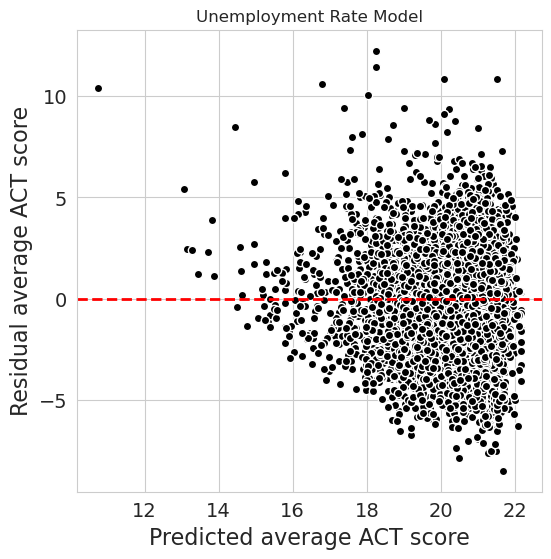

In [173]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat, model_rate_unemployment.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)
plt.title("Unemployment Rate Model")

plt.tick_params(labelsize=14)

plt.show()

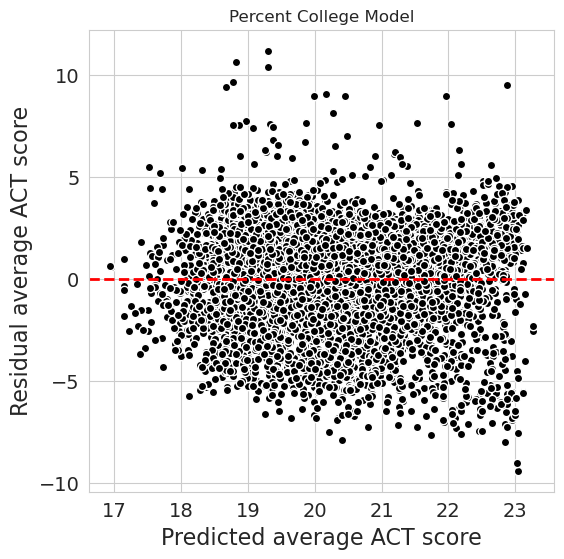

In [174]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat2, model_percent_college.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)
plt.title("Percent College Model")

plt.tick_params(labelsize=14)

plt.show()

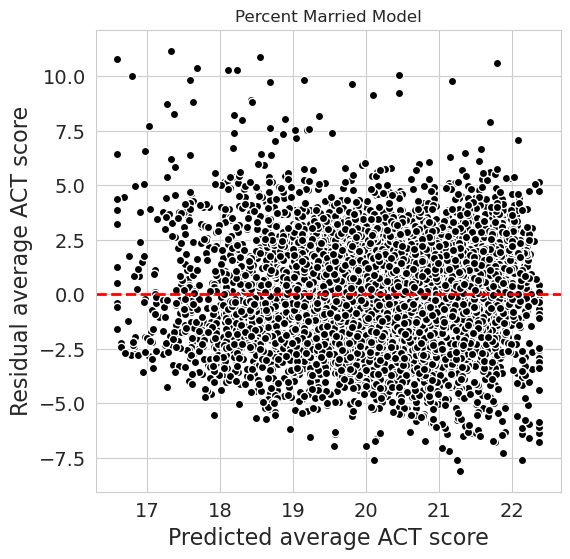

In [172]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat3, model_percent_married.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)
plt.title("Percent Married Model")

plt.tick_params(labelsize=14)

plt.show()

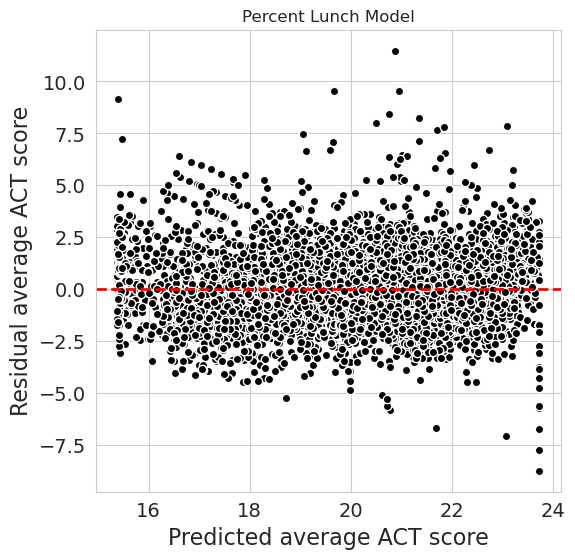

In [175]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat4, model_percent_lunch.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)
plt.title("Percent Lunch Model")

plt.tick_params(labelsize=14)

plt.show()

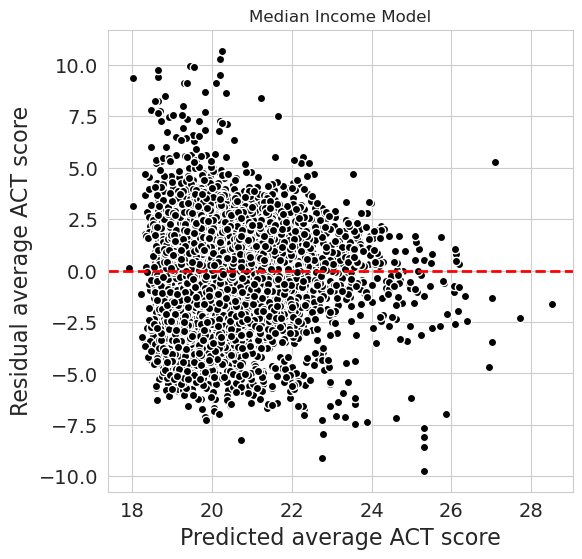

In [176]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat5, model_median_income.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)
plt.title("Median Income Model")

plt.tick_params(labelsize=14)

plt.show()

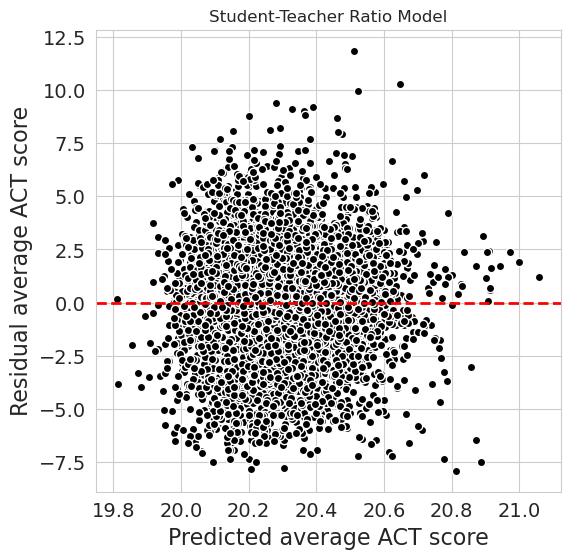

In [177]:
plt.figure(figsize=(6, 6))

plt.plot(y_hat6, model_pupil_teach_ratio.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)
plt.title("Student-Teacher Ratio Model")

plt.tick_params(labelsize=14)

plt.show()

While only percent_lunch, percent_married, and percent_college looked to have fairly linear graphs, it is unclear if there would be a better way to represent the rate_unemployment, median income, and student-teacher ratio models through a nonlinear regression. As there does not seem to be any clearly better way to present this data, we will continue to use these linear regression models in putting together a multiple linear regression model below.

### Multiple Linear Regression Model

In [178]:
model = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_married + median_income + percent_lunch + pupil_teach_ratio',
    data=df_filtered).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     2037.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        02:32:37   Log-Likelihood:                -13259.
No. Observations:                7205   AIC:                         2.653e+04
Df Residuals:                    7198   BIC:                         2.658e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.3279      0.15

Here, we can see that the r-squared value is higher than any of the individual models, with a value of 0.629. It is also important to note that two of our previously statistically significant variables are no longer statistically significant, namely the percent_married and median_income variables. This is probably due to their shared correlation with each other and the percent_college variable, as we saw when we did our initial correlation matrix. From here, we're going to look at the mean absolute error to get a sense of how far off our model is on average.

In [180]:
mean_absolute_error(df_filtered['average_act'], model.predict())

1.1412741880572677

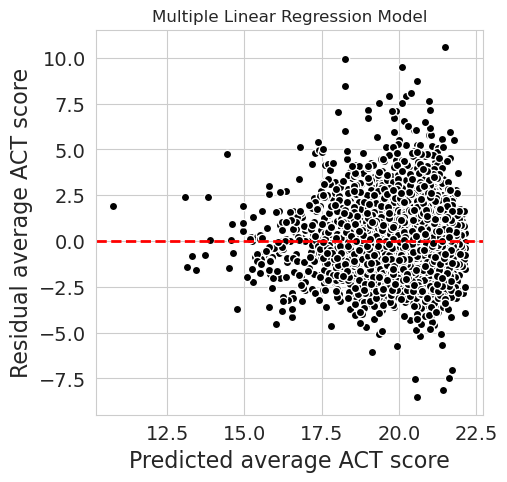

In [183]:
y_hat_m = model.predict()

plt.figure(figsize=(5, 5))

plt.plot(y_hat, model.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)
plt.title("Multiple Linear Regression Model")

plt.tick_params(labelsize=14)

plt.show()

Here, we can see that our mean absolute error is the best of any of our models, and that the residual regression line seems to somewhat accurately reflect the shape of the data, or at least accurately enough that it doesn't warrant an attempt at nonlinear modeling. From here, we'll want to try and simplify the model while keeping the same level of accuracy. To do so, we're going to try removing the non-statistically significant variables and see whether the impact to our accuracy is negligible once they have been removed.

In [185]:
model_reduced = smf.ols(
    formula='average_act ~ rate_unemployment + percent_college + percent_lunch + pupil_teach_ratio',
    data=df_filtered).fit()

print(model_reduced.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     3056.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        02:44:12   Log-Likelihood:                -13260.
No. Observations:                7205   AIC:                         2.653e+04
Df Residuals:                    7200   BIC:                         2.656e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.2782      0.12

We can see that our r-squared value is unchanged, so the accuracy of the model seems to be the same without the removed variables.

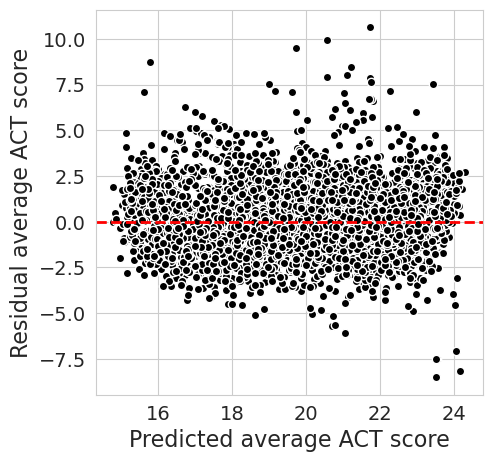

In [186]:
y_hat_r = model_reduced.predict()

plt.figure(figsize=(5, 5))

plt.plot(y_hat_r, model_reduced.resid, 'ko', mec='w')
plt.axhline(0, color='r', linestyle='dashed', lw=2)

plt.xlabel('Predicted average ACT score', fontsize=16)
plt.ylabel('Residual average ACT score', fontsize=16)

plt.tick_params(labelsize=14)

plt.show()

Here, we can see our new residual regression line seems to fit the data much better in a linear fashion, and so with this model, it makes sense to use a linear regression line to approximate the relationship between our variables and the ACT scores.

In [188]:
mean_absolute_error(df_filtered['average_act'], model_reduced.predict())

1.141342184790436

Our mean absolute error for the new model is nearly identical to our old one, showing we have little to no loss in accuracy, and removing those variables does not seem to have had much of an impact on our model.

To further verify this, we'll use an ANOVA to test the significance of the difference between the models and make sure that we are not losing a statistically significant amount of accuracy by removing them.

In [192]:
mae_full = mean_absolute_error(df_filtered['average_act'], model.predict())
mae_reduced = mean_absolute_error(df_filtered['average_act'], model_reduced.predict())

r2_full = model.rsquared
r2_reduced = model_reduced.rsquared

pd.DataFrame({'Mean Absolute Error': [mae_full, mae_reduced],
              'R-squared': [r2_full, r2_reduced]},
              index=['full model', 'reduced model']).round(4)

,Mean Absolute Error,R-squared
full model,1.1413,0.6294
reduced model,1.1413,0.6293


In [190]:
anova_lm(model_reduced, model)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,7200.0,16736.182041,0.0,NaN,NaN,NaN
1,7198.0,16735.035900,2.0,1.146141,0.246487,0.781548


As we can see, the p-value, represented by the column Pr(>F) is greater than 0.05, so the difference between the two models is not statistically significant, and we can thus proceed with this as our final model.

### Scaling the Predictor Variables

The final step in this analysis is going to be scaling the predictor variables so we can directly compare the impact each variable has on the average ACT scores.

We start by scaling the predictor variables to have a mean of 0 and a standard deviation of 1, so we can compare the relative significance of each variable.

In [202]:
predictor_variables = ['rate_unemployment', 'percent_college', 'percent_lunch', 'pupil_teach_ratio']

scaled_columns = [var + '_normalized' for var in predictor_variables]
scaler = StandardScaler().fit(df_filtered[predictor_variables])

df_filtered[scaled_columns] = scaler.transform(df_filtered[predictor_variables])

/tmp/ipykernel_11425/2705825195.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,rate_unemployment,percent_college,percent_married,median_income,average_act,percent_lunch,year,state,zip_code,school_type,school_level,charter,pupil_teach_ratio,rate_unemployment_normalized,percent_college_normalized,percent_lunch_normalized,pupil_teach_ratio_normalized
0,100001600143,0.117962,0.445283,0.346495,42820.0,20.433455,0.066901,2016-2017,DE,19804,Regular School,High,Yes,23.36,0.384986,-0.773956,-1.468243,1.989375
1,100008000024,0.063984,0.662765,0.767619,89320.0,19.498168,0.112412,2016-2017,DE,19709,Regular School,High,No,17.23,-0.574543,0.544613,-1.273812,0.305822
2,100008000225,0.056460,0.701864,0.713090,84140.0,19.554335,0.096816,2016-2017,DE,19709,Regular School,High,No,17.24,-0.708300,0.781671,-1.340441,0.308569
3,100017000029,0.044739,0.692062,0.641283,56500.0,17.737485,0.296960,2016-2017,DE,19958,Regular School,High,No,14.35,-0.916665,0.722240,-0.485385,-0.485146
4,100018000040,0.077014,0.640060,0.834402,54015.0,18.245421,0.262641,2016-2017,DE,19934,Regular School,High,No,14.90,-0.342935,0.406959,-0.632003,-0.334093


After creating our normalized variables, we create our new model with normalized values, so we can see the relative impact of each of our predictor variables.

In [204]:
model_normalized = smf.ols(
    formula='average_act ~ rate_unemployment_normalized + percent_college_normalized + percent_lunch_normalized + pupil_teach_ratio_normalized',
    data=df_filtered).fit()

print(model_normalized.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     3056.
Date:                Wed, 22 Oct 2025   Prob (F-statistic):               0.00
Time:                        03:03:21   Log-Likelihood:                -13260.
No. Observations:                7205   AIC:                         2.653e+04
Df Residuals:                    7200   BIC:                         2.656e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

Here, we can see that the variable that had the most impact on the average ACT scores was percent_lunch, with a 1 point change in percent_lunch having an impact almost 7 times as high as the next highest variable, percent_college. This illustrates just how important this variables relationship with the average ACT score is. 